In [2]:
%load_ext Cython

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.ensemble as ske
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV , train_test_split
from stroopwafel import constants , utils
from sklearn import metrics , tree
import seaborn as sns
from numpy import array as A
from sklearn.utils import shuffle
import cython
from cython.parallel import prange , parallel
from cython import nogil
import random
from sklearn.preprocessing import OneHotEncoder
import pickle
from mpl_toolkits import mplot3d

# Function definition



In [4]:
%%cython

# cython: auto_pickle=False
# distutils: extra_compile_args = /openmp
# distutils: extra_link_args = /openmp
# cython: boundscheck = False

import cython
import numpy as np
cimport numpy as np
cimport openmp
from cython.parallel import prange, parallel, threadid
from libc.stdlib cimport malloc, realloc, free, abort
from libc.math cimport cos , sin , sqrt , tan

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.nonecheck(False)
@cython.cdivision(True)

cdef Hot_Encode(int L , int n_class , int n_var , double [:,:] dataset , int [:,:] labels , int num_t):
    
    cdef double [:,:] DATASET = dataset[0:L,:]  
    cdef int [:,:] LABELS = labels[0:L,:]
    cdef int i , j
    cdef int [:] merge = labels[:,0]
    cdef int [:] bbh = labels[:,1]
    cdef double [:,:,:] ds
    
    if n_class >= n_var:
        ds = np.zeros( (2 , L , n_class) )
    else:
        ds = np.zeros( (2 , L , n_var) )

    for i in prange(L , nogil = True , schedule = 'static' , num_threads = num_t):
        
        for j in range(n_var):
            ds[0,i,j] = DATASET[i,j]
        
        if merge[i] == 1: # BBH MERGER

            ds[1,i,0] = 1
                
        else: # BBH NO MERGER:
            
            ds[1,i,1] = 1
        
    return ds

def hotencode(int L , int n_class , int n_var , double [:,:] dataset , int [:,:] labels , int num_t):
    return Hot_Encode(L , n_class , n_var , dataset , labels , num_t)

print('Hotencoding ok!')

def Equalize(variable , label , minimum , n , L , least):
    
    lab = []
    var = []
    
    for i in range(L):
        if label.iloc[i,least] == 1:
            lab.append(label.iloc[i].values)
            var.append(variable.iloc[i].values)

    for N in range(n):
        k = 0
        for j in range(L):
            if label.iloc[j,N] == 1 and k <= minimum-1 and N != least:
                lab.append(label.iloc[j].values)
                var.append(variable.iloc[j].values)
                k += 1
                
    return np.array(lab) , np.array(var)

print('Equalize ok!')

Hotencoding ok!
Equalize ok!


# Dataset Creation for hyperparameters optimization

In [38]:
dataset = pd.read_csv('C:/Users/mbaro/OneDrive/Desktop/dataset_ML/SAMPLES.csv')#'samples_finale.csv')
print(len(dataset))
dataset = dataset[ dataset.bbh == 1. ]
dataset = shuffle(dataset)

VAR = dataset[['--initial-mass-1' , 'q' , '--metallicity' , '--semi-major-axis' , '--eccentricity']].astype(float)
LAB = dataset[['is_hit']].astype(int)

n = 2
m = 5
threads = 8
L = 10000#int(len(dataset))

ds = hotencode(L , n , m , VAR.values , LAB.values , threads)

variables = np.array(ds[0,:,0:m])
labels = np.array(ds[1,:,0:n]).astype(int)

names = ['BBH_MERGE' , 'BBH_NO_MERGE']

LEAST = []
c = 0
for i in range(n):
    c += 100*(np.count_nonzero(labels[:,i] == 1)/len(labels[:,i]))
    print(names[i] ,  '{:.2f}..'.format(100*(np.count_nonzero(labels[:,i] == 1)/len(labels[:,i]))) , '% ---->' , np.count_nonzero(labels[:,i] == 1))
    LEAST.append(np.count_nonzero(labels[:,i] == 1))
    
least_repr = np.argmin(LEAST)
    
if c >= 99.9:
    print('')
    print('OK! All dataset is represented!')
    
counts = np.zeros(n)
for i in range(n):
    counts[i] = np.count_nonzero(labels[:,i] == 1)
minimum = int(np.min(counts))

print('')
print('Minimum = ' , minimum)
print('')

LABELS = pd.DataFrame(labels , columns = names , dtype = int)
VARIABLES = pd.DataFrame(variables , columns = ['M1' , 'q' , 'Z' , 'a' , 'e'])

lab , var = Equalize(VARIABLES , LABELS , minimum , n , L , least_repr)

for i in range(n):
    print(names[i] ,  '{:.2f}..'.format(100*(np.count_nonzero(lab[:,i] == 1)/len(lab[:,i]))) , '% ---->' , np.count_nonzero(lab[:,i] == 1))

2000002
BBH_MERGE 27.61.. % ----> 2761
BBH_NO_MERGE 72.39.. % ----> 7239

OK! All dataset is represented!

Minimum =  2761

BBH_MERGE 50.00.. % ----> 2761
BBH_NO_MERGE 50.00.. % ----> 2761


In [19]:
datasetX = var

datasetY = lab

Xtrain, Xtest, ytrain, ytest = train_test_split( datasetX , datasetY , test_size = 0.000001 , random_state = 311996 )

print(len(Xtrain) , len(ytrain) , len(Xtest) , len(ytest))

1559 1559 1 1


# Random Search

In [20]:
# Number of trees in random forest
n_estimators = np.arange(100 , 1100 , 100).tolist()

# Number of features to consider at every split
max_features = ['sqrt' , 'log2' , 'auto']

# Maximum number of levels in tree
max_depth = np.arange(0,110,10 , dtype = int).tolist()
max_depth.append(None)
max_depth.append(np.arange(1,10).tolist())

# Minimum number of samples required to split a node
min_samples_split = np.arange(2,11,1).tolist()

# Minimum number of samples required at each leaf node
min_samples_leaf = np.arange(2,11,1).tolist()

# Method of selecting samples for training each tree
bootstrap = [True , False]

criterion = ["gini" , "entropy"]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
print(random_grid)

# Use the random grid to search for best hyperparameters

# Random search of parameters, using 5 fold cross validation, 
# search across 60 different combinations, and use all available cores

rf_random = RandomizedSearchCV( estimator = ske.RandomForestClassifier(n_jobs = -1) , 
                                param_distributions = random_grid , n_iter = 500 ,
                                cv = 5, verbose = 2 , random_state = 3117102616 , n_jobs = -1 , pre_dispatch = '2*n_jobs' ) 

# Fit the random search model
rf_random.fit(var , lab)

print(rf_random.best_params_)

print('Best accuracy score: %.4f' , rf_random.best_score_)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['sqrt', 'log2', 'auto'], 'max_depth': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None, [1, 2, 3, 4, 5, 6, 7, 8, 9]], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 20.6min finished


{'n_estimators': 400, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'gini', 'bootstrap': False}
Best accuracy score: %.4f 0.7147435897435898


# Grid Search

In [21]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [None , 10 , 20 , 30 , 40],
    'n_estimators': [325 ,350 , 375 , 400 , 425 , 450 , 475],
    'min_samples_leaf': [2],
    'min_samples_split': [7],
    'max_features': ['log2'],
    'bootstrap': [False],
    'criterion': ['gini']
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = ske.RandomForestClassifier(n_jobs = -1),
                           param_grid = param_grid, 
                           cv = 5, n_jobs = -1, verbose = 2 , pre_dispatch = '2*n_jobs')

grid_search.fit(Xtrain , ytrain)

print(grid_search.best_params_)
print('Best accuracy score: %.4f' , grid_search.best_score_)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:   59.6s finished


{'bootstrap': False, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 375}
Best accuracy score: %.4f 0.7953685382141974


# Dataset creation for training and testing

In [5]:
dataset = pd.read_csv('C:/Users/mbaro/OneDrive/Desktop/dataset_ML/SAMPLES.csv')#'samples_finale.csv')
dataset = dataset[ dataset.bbh == 1.]
print(len(dataset))
dataset = shuffle(dataset)

VAR = dataset[['--initial-mass-1' , 'q' , '--metallicity' , '--semi-major-axis' , '--eccentricity']].astype(float)
LAB = dataset[['is_hit']].astype(int)# , 'bbh' ,]].astype(int)

n = 2
m = 5
threads = 8
L = int(len(dataset))

ds = hotencode(L , n , m , VAR.values , LAB.values , threads)

variables = np.array(ds[0,:,0:m])
labels = np.array(ds[1,:,0:n]).astype(int)

names = ['BBH_MERGE' , 'BBH_NON_MERGE']

LEAST = []
c = 0
for i in range(n):
    c += 100*(np.count_nonzero(labels[:,i] == 1)/len(labels[:,i]))
    print(names[i] ,  '{:.2f}..'.format(100*(np.count_nonzero(labels[:,i] == 1)/len(labels[:,i]))) , '% ---->' , np.count_nonzero(labels[:,i] == 1))
    LEAST.append(np.count_nonzero(labels[:,i] == 1))
    
least_repr = np.argmin(LEAST)
    
if c >= 99.9:
    print('')
    print('OK! All dataset is represented!')
    
counts = np.zeros(n)
for i in range(n):
    counts[i] = np.count_nonzero(labels[:,i] == 1)
minimum = int(np.min(counts))

print('')
print('Minimum = ' , minimum)
print('')

LABELS = pd.DataFrame(labels , columns = names , dtype = int)
VARIABLES = pd.DataFrame(variables , columns = ['M1' , 'q' , 'Z' , 'a' , 'e'])

lab , var = Equalize(VARIABLES , LABELS , minimum , n , L , least_repr)#LABELS.values , VARIABLES.values#

for i in range(n):
    print(names[i] ,  '{:.2f}..'.format(100*(np.count_nonzero(lab[:,i] == 1)/len(lab[:,i]))) , '% ---->' , np.count_nonzero(lab[:,i] == 1))

datasetX = var

datasetY = lab

Xtrain, Xtest, ytrain, ytest = train_test_split( datasetX , datasetY ,
                                                 test_size = 0.2 , random_state = 754863321 )

print(len(Xtrain) , len(ytrain) , len(Xtest) , len(ytest))

C:\Users\mbaro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


440139
BBH_MERGE 27.99.. % ----> 123199
BBH_NON_MERGE 72.01.. % ----> 316940

OK! All dataset is represented!

Minimum =  123199

BBH_MERGE 50.00.. % ----> 123199
BBH_NON_MERGE 50.00.. % ----> 123199
197118 197118 49280 49280


# Training

In [6]:
final_model = ske.RandomForestClassifier(n_estimators = 375 , min_samples_split = 7 ,
                                         min_samples_leaf = 2 ,
                                         max_features = 'log2' , max_depth = 30 ,
                                         bootstrap = False , criterion = "gini" , n_jobs = -1)
final_model.fit(Xtrain , ytrain)

RandomForestClassifier(bootstrap=False, max_depth=30, max_features='log2',
                       min_samples_leaf=2, min_samples_split=7,
                       n_estimators=375, n_jobs=-1)

# Testing

In [7]:
y_pred = final_model.predict(Xtest)

print('Mean Absolute Error:', metrics.mean_absolute_error(ytest, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ytest, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, y_pred)))
print("Accuracy:",metrics.accuracy_score(ytest, y_pred))

Mean Absolute Error: 0.07909902597402597
Mean Squared Error: 0.07909902597402597
Root Mean Squared Error: 0.2812454905843398
Accuracy: 0.920900974025974


In [ ]:
filename = ''
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(Xtest, ytest)
y_pred = loaded_model.predict(Xtest)
print(result)

print('Mean Absolute Error:', metrics.mean_absolute_error(ytest, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ytest, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, y_pred)))
print("Accuracy:",metrics.accuracy_score(ytest, y_pred))

# Feature Importance Histogram

a          0.305175
e          0.197397
Z          0.191713
M$_{1}$    0.161539
q          0.144176
dtype: float64


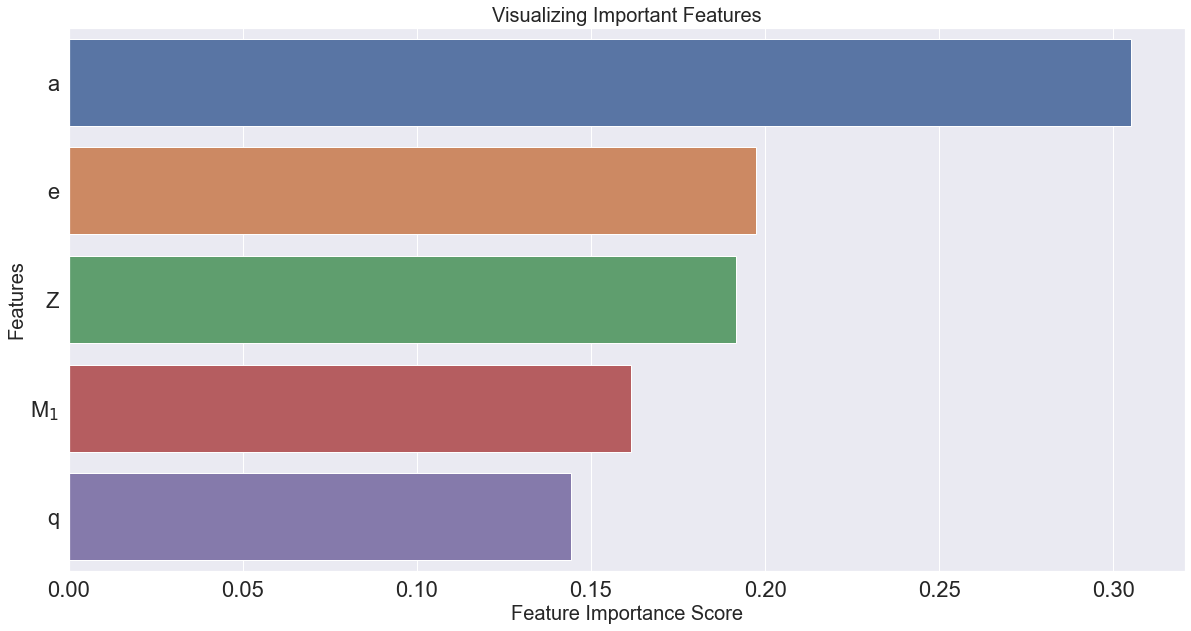

In [8]:
fig = plt.figure(figsize = [20,10])
feature_imp = pd.Series(final_model.feature_importances_ , index=['M$_{1}$' , 'q' , 'Z' , 'a' , 'e']).sort_values(ascending=False)
print(feature_imp)

sns.set(font_scale=2)

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score' , fontsize = 20)
plt.ylabel('Features' , fontsize = 20)
plt.title("Visualizing Important Features" , fontsize = 20)
plt.show()

fig.savefig('importance.png')

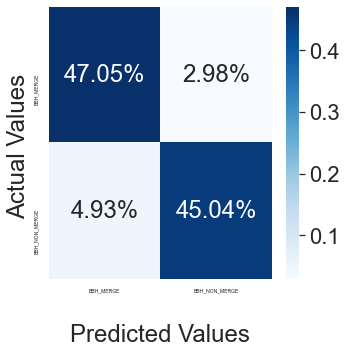

In [9]:
# Confusion matrix
# Evaluate confusion matrix

cm = metrics.confusion_matrix(ytest.argmax(axis=1), y_pred.argmax(axis=1))

##############################################################################

fig = plt.figure(figsize = [5,5])

ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

ax.set_xticklabels(names , fontsize = 5)
ax.set_yticklabels(names , fontsize = 5)

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.show()
fig.savefig('conf_matrix_perc.png')

##############################################################################

#fig = plt.figure(figsize = [10,10])
#ax = sns.heatmap(cm, annot=True, fmt='1', cmap='Blues')

#ax.set_xticklabels(names , fontsize = 5)
#ax.set_yticklabels(names , fontsize = 5)

#ax.set_xlabel('\nPredicted Values')
#ax.set_ylabel('Actual Values ')

#plt.show()

#fig.savefig('conf_matrix_abs.png')

In [19]:
filename = 'RandomForestBBH_BINARY_2million.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [11]:
sns.reset_orig()
plt.figure(figsize = [10,10])
for i in range(len(ytest)):
    if ytest[i].tolist() == y_pred[i].tolist():
        plt.plot(Xtrain[i,3] , Xtrain[i,4] , 'k.' , markersize = 2)
    else:
        plt.plot(Xtrain[i,3] , Xtrain[i,4] , 'y.' , markersize = 2)
plt.xlabel('a [AU]' , fontsize = 20)
plt.ylabel('e' , fontsize = 20)
plt.plot(0,0,'k-' , label = 'Correct')
plt.plot(0,0,'y-', label = 'Incorrect')
plt.legend()
plt.show()

C:\Users\mbaro\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


KeyboardInterrupt: 

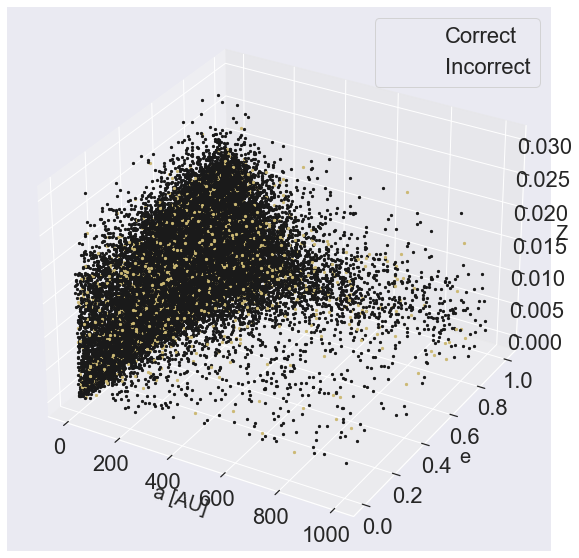

In [10]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection ="3d")

for i in range(len(ytest)):
    if ytest[i].tolist() == y_pred[i].tolist():
        ax.scatter3D(Xtrain[i,3] , Xtrain[i,4] , Xtrain[i,2] , c = 'k' , s = 5)
    else:
        ax.scatter3D(Xtrain[i,3] , Xtrain[i,4] , Xtrain[i,2] , c = 'y' , s = 5)
        
ax.set_xlabel('a [AU]' , fontsize = 20)
ax.set_ylabel('e' , fontsize = 20)
ax.set_zlabel('Z' , fontsize = 20)
ax.scatter3D(0,0,0, c = 'k' , s = 0, label = 'Correct')
ax.scatter3D(0,0,0, c = 'y', s = 0, label = 'Incorrect')
plt.legend()
plt.show()

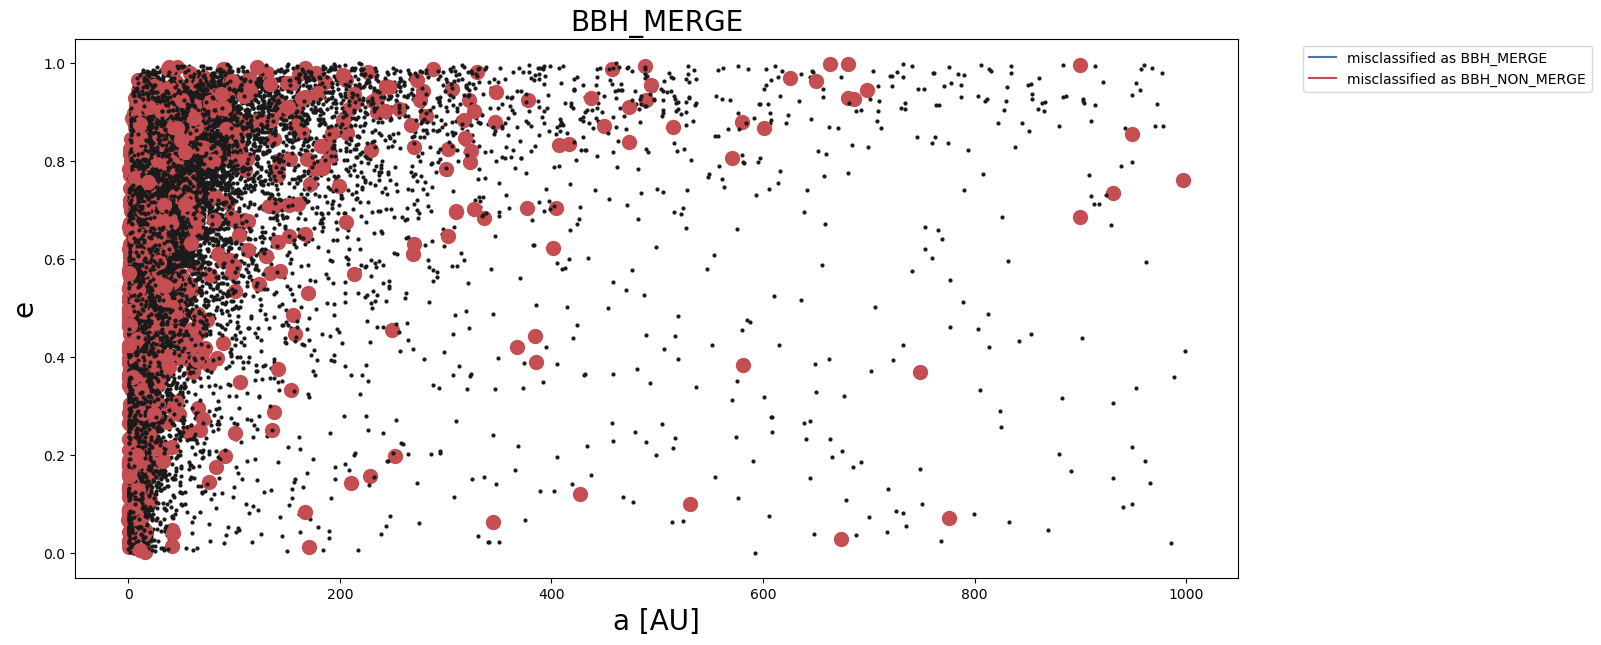

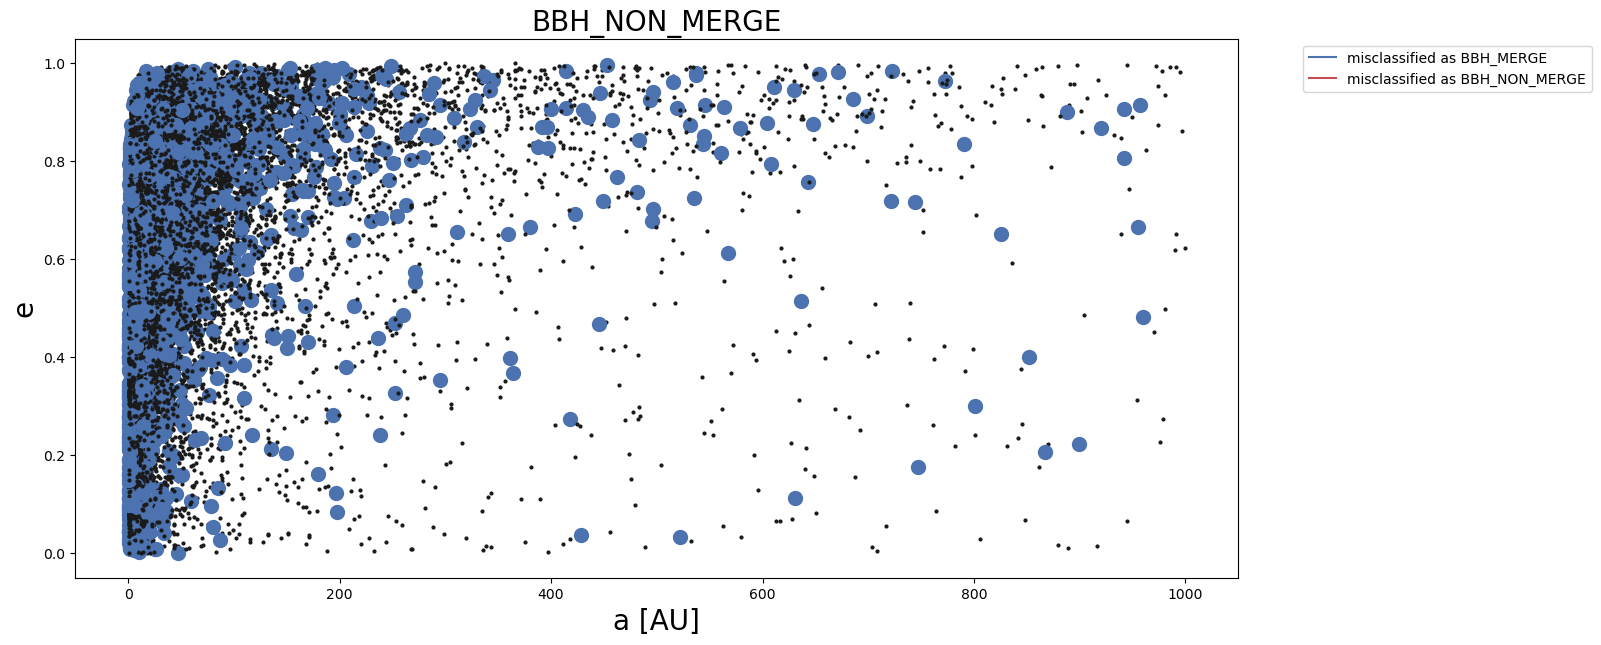

In [15]:
# FAI LA PCA E PLOTTA TUTTO IN 2 D e 3 D, POI FAI IL CLUSTERING
sns.reset_defaults()
colors = [str('b') , str('r')]

Y = np.eye(2)

for k in range(len(Y[0])):
    fig = plt.figure(figsize = [15,7])
    for i in range(len(ytest)):
        a = ytest[i].tolist()
        b = Y[k].tolist()
        c = y_pred[i].tolist()
        if a == b:
            if ytest[i].tolist() == y_pred[i].tolist():
                plt.plot(Xtrain[i,3] , Xtrain[i,4], 'ko' , markersize = 2)
            else:
                for j in range(len(Y[:,0])):
                    if c == Y[j].tolist() and c != Y[k].tolist():
                        plt.plot(Xtrain[i,3] , Xtrain[i,4], colors[j] + 'o' , markersize = 10)
                        
    for f in range(len(colors)):
        plt.plot(0,0,colors[f]+'-',markersize = 0 , label = 'misclassified as ' + names[f])
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    
    plt.title(names[k] , fontsize = 20)
    plt.ylabel('e' , fontsize  = 20)
    plt.xlabel('a [AU]' , fontsize  = 20)
    plt.show()
    fig.savefig('PCA_2dim_binary_' + str(k) + '.png')

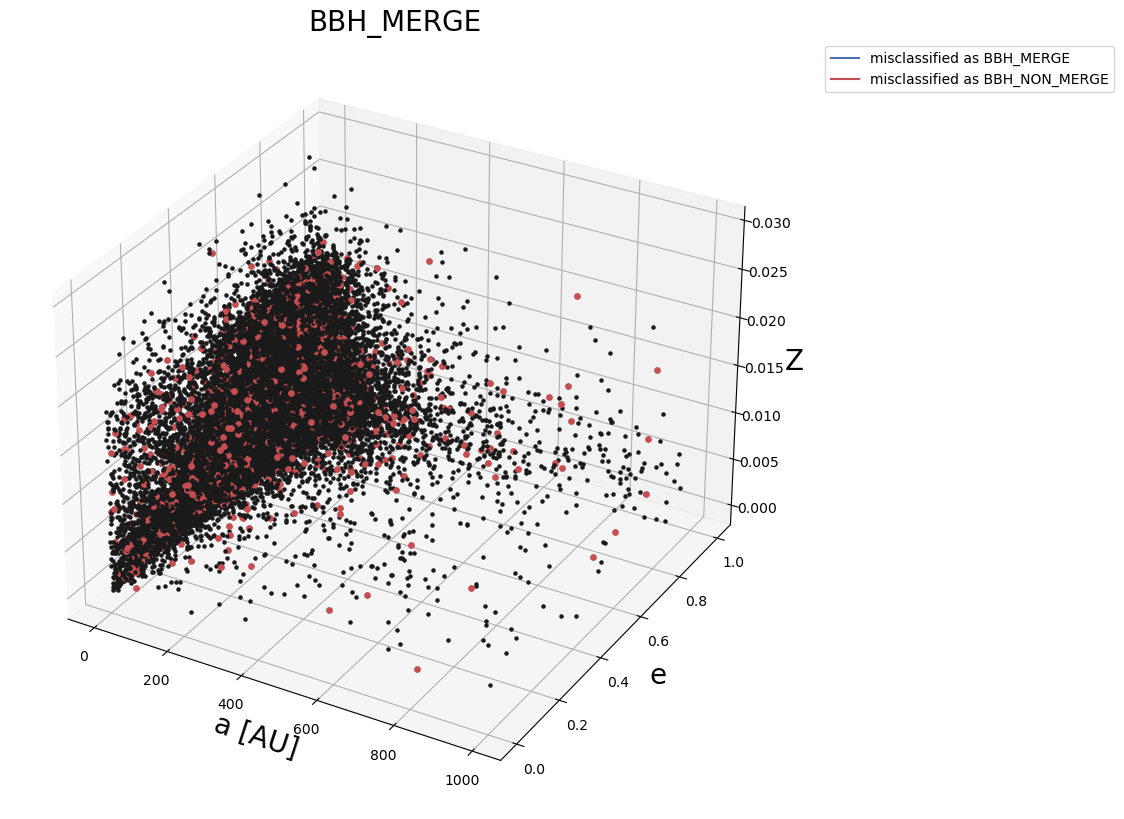

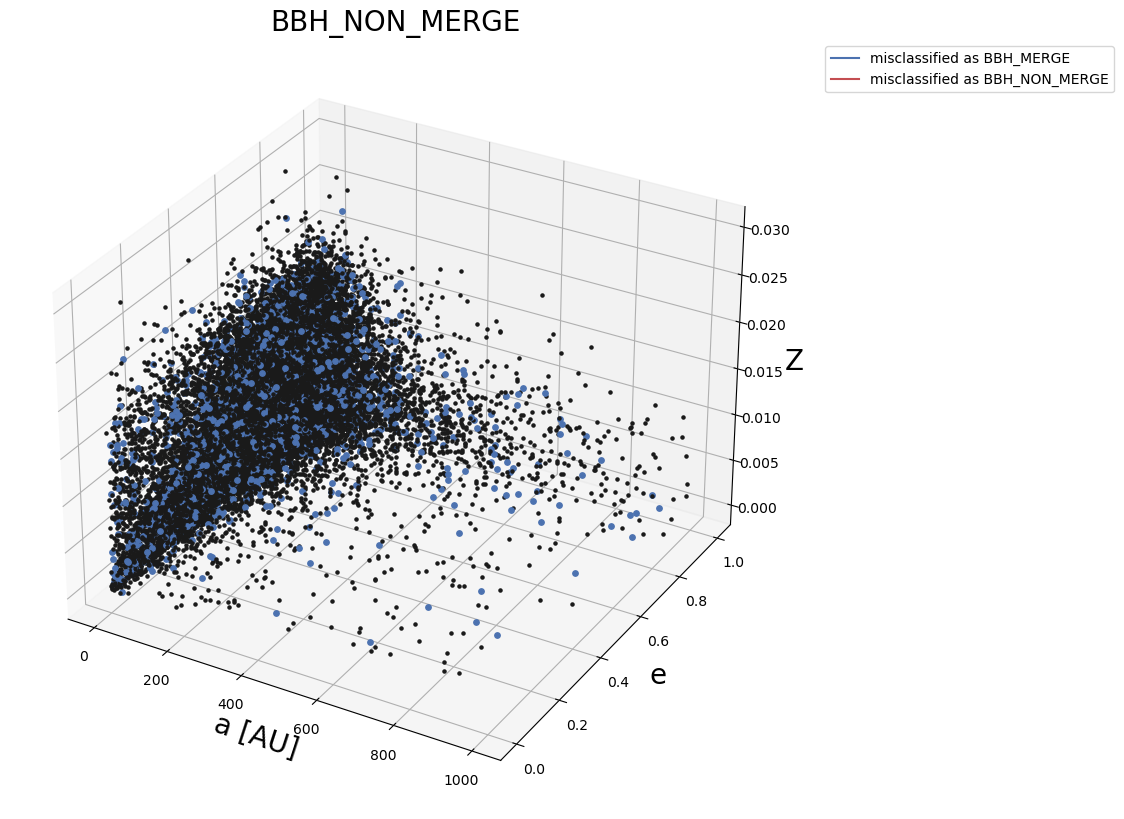

In [18]:
# FAI LA PCA E PLOTTA TUTTO IN 2 D e 3 D, POI FAI IL CLUSTERING
sns.reset_defaults()
colors = [str('b') , str('r')]

Y = np.eye(2)

for k in range(len(Y[0])):
    fig = plt.figure(figsize = (10, 10))
    ax = plt.axes(projection ="3d")
    for i in range(len(ytest)):
        a = ytest[i].tolist()
        b = Y[k].tolist()
        c = y_pred[i].tolist()
        if a == b:
            if ytest[i].tolist() == y_pred[i].tolist():
                ax.scatter3D(Xtrain[i,3] , Xtrain[i,4], Xtrain[i,2] , c = 'k' , s = 5)
            else:
                for j in range(len(Y[:,0])):
                    if c == Y[j].tolist() and c != Y[k].tolist():
                        ax.scatter3D(Xtrain[i,3] , Xtrain[i,4], Xtrain[i,2] , c = colors[j] , s = 15)
                        
    for f in range(len(colors)):
        plt.plot(0,0,0, c = colors[f] ,markersize = 1 , label = 'misclassified as ' + names[f])
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    
    ax.set_title(names[k] , fontsize = 20)
    ax.set_xlabel('a [AU]' , fontsize = 20)
    ax.set_ylabel('e' , fontsize = 20)
    ax.set_zlabel('Z' , fontsize = 20)
    plt.show()
    fig.savefig('PCA_3dim_binary_' + str(k) + '.png')

In [29]:
fn = ['M1' , 'q' , 'Z' , 'a' , 'e']
cn = names

ext = final_model.estimators_[0]

sns.reset_defaults()

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20), dpi=500)
out = tree.plot_tree(ext,
               feature_names = fn, 
               class_names=cn,
               filled = True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)

fig.savefig('rf_individualtree.png')